# 2022 GWU Datathon
# Classification of Twitter engagement using text and numeric features
## Muzhe Guo  muzheguo@gwu.edu 
### 2022.01.14

# 1 Summary 

In this project, we analyzed the engagement of Twitter based on more than 1.1 million tweet data. We create a target variable that characterizes the engagement of each tweet: the sum of the number of favourites and retweets of the tweet. We further categorized engagement into five balanced levels based on the level of engagement: very low, low, moderate, high, and very high.

The question we explore is: can we use user information and the text of the tweet itself to predict engagement of this tweet? Keep this in mind, we created several models for classification of tweet engagement. Based on the inputs of the models, there are three types of models. The first is the classification model with input of numerical information of tweets, such as Naive bayes, logistic regression, and KNN. The second is the classification model with input of tweet text, here we use one of the most popular NLP models, BERT, to do classification task. 

The third model is a combination of the above two types of models, which exploits both the features returned by BERT on text classification and the numerical features in the original dataset. In other words, we created a neural network model that can utilize both text and numerical variables for engagement prediction, simply named BERT + DNN. Results on a test dataset of more than 220,000 tweets show that this new model can indeed improve the accuracy of engagement classification.

# 2 Project pipeline

## 2.1 Data Overview

First we look at the sample data, which is a random sample of twenty-five thousand of the total data. From this we learn that there are 90 variables in this data. The data includes :user data (like name, screen name, follower count, verified, etc); tweet information (like tweet text, created at, etc.); engagement data (like retweet count, favorite count, reply count, etc). There are a lot of missing values and invalid information such as links in the dataset. So we need to do data preprocessing in the next section.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [77]:
# from google.colab import drive
# drive._mount('/content/drive')
# random_sample = pd.read_csv(r"/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/random_sample.csv")
random_sample = pd.read_csv (r'./random_sample.csv')
random_sample.head(3)

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,1060370282,1392106273223610379,2021-05-11T13:16:14Z,RepMullin,📲 REMINDER: I will be hosting a Telephone Town...,Twitter Web App,180,NaN,NaN,NaN,...,4902,1388,2013-01-04T12:43:55Z,True,https://t.co/Qv5teppuYQ,http://www.mullin.house.gov,NaN,https://pbs.twimg.com/profile_banners/10603702...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9366845588...
1,818554054309715969,1284947108827746305,2020-07-19T20:23:58Z,SenJackyRosen,The best way the Senate can honor the legacy o...,Twitter for iPhone,110,NaN,NaN,NaN,...,8870,611,2017-01-09T20:24:29Z,True,https://t.co/fq26igiB6n,http://www.rosen.senate.gov,NaN,https://pbs.twimg.com/profile_banners/81855405...,NaN,http://pbs.twimg.com/profile_images/1085182795...
2,385429543,988119683831234560,2018-04-22T18:17:45Z,RepMcNerney,"Today, many of you will be celebrating #EarthD...",Twitter for iPhone,227,NaN,NaN,NaN,...,2781,593,2011-10-05T13:52:58Z,True,https://t.co/So4mXjTwdK,http://mcnerney.house.gov,NaN,https://pbs.twimg.com/profile_banners/38542954...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/4536029670...


## 2.2 Data Preprocessing 

There are 90 variables in the original data. However, some variables have so many missing values that they are of little value to the analysis of the data. 

Based the 25000 random samples, we select those variables with less than 50% missing values, leaving 30 valid variables. 

Since the various link (url) variables are also worthless, we also remove them, leaving 23 variables. To save memory, we only read these 23 variables from the full tweet data, and then proceeded to the next step.

In [78]:
NA_ratio = [random_sample[col].isnull().sum()/len(random_sample) for col in random_sample.columns]
valid_columns = [random_sample.columns[i] for i in range(len(random_sample.columns)) if NA_ratio[i] < 0.5] 
print("Number of vaild variables:",len(valid_columns))  #Variables with less than 50% of missing values
selected_columns = [col for col in valid_columns if col[-3:]!= 'url']
print("Number of selected variables:",len(selected_columns))  #Valid variables expect for url variables 

print("--------------------------------- Selected Variables: ----------------------------------")
print(selected_columns)

Number of vaild variables: 30
Number of selected variables: 23
--------------------------------- Selected Variables: ----------------------------------
['user_id', 'status_id', 'created_at', 'screen_name', 'text', 'source', 'display_text_width', 'is_quote', 'is_retweet', 'favorite_count', 'retweet_count', 'lang', 'name', 'location', 'description', 'protected', 'followers_count', 'friends_count', 'listed_count', 'statuses_count', 'favourites_count', 'account_created_at', 'verified']


In [79]:
import warnings
warnings.filterwarnings('ignore')
random_sample = random_sample[selected_columns] 
#full_tweets_data = pd.read_csv(r"/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/full_tweets.csv", usecols=selected_columns)
full_tweets_data = pd.read_csv(r"./full_tweets.csv", usecols=selected_columns)

There are seven steps in the data preprocessing:
- We only keep verified users in order to avoid some fake tweets.
- We only keep tweets in English for the convenience of text processing in the future.
- We create a variable called $Days\_span$, which records the time interval between when the user creates an account and when the tweet is posted
- We take the time in years for the variables $tweet\_created\_at$ and $user\_created\_at$
- We create a target variable, called $engagement$, that characterizes the engagement of each tweet: the sum of the number of favourites and retweets of the tweet.
- We delete the rows with the missing values.
- We perform a logarithmic transformation of the user's numeric variables the and target variable ($followers\_count$, $friends\_count$, $listed\_count$, $statuses\_count$, $favourites\_count$, $engagement$). To prevent infinite values, we manually add 1 to all values in these variables before the logarithmic transformation

After the above data pre-processing operation, there are 110,1095 rows of data left.

In [80]:
# keep verified = TRUE & language = English
full_tweets_data = full_tweets_data[(full_tweets_data['verified'] == True) & (full_tweets_data['lang'] == 'en')]
full_tweets_data = full_tweets_data.reset_index(drop=True)  #reindex 
full_tweets_data = full_tweets_data.drop(['status_id','verified', 'lang'], axis = 1)  #remove columns 

# create time span variable
Ttype = "%Y-%m-%dT%H:%M:%SZ"
Time_diff = [datetime.strptime(full_tweets_data['created_at'][i],Ttype) -  
             datetime.strptime(full_tweets_data['account_created_at'][i],Ttype)
             for i in range(len(full_tweets_data))] 
Days_diff = [d.days + d.seconds/(24*60*60) for d in Time_diff]
full_tweets_data['Days_span'] = Days_diff  #Add one variable: Time span from creating to tweeting

# simplify the time variable
full_tweets_data['tweet_year'] = [int(full_tweets_data['created_at'][i][0:4]) 
                                  for i in range(len(full_tweets_data))]
full_tweets_data['account_year'] = [int(full_tweets_data['account_created_at'][i][0:4]) 
                                    for i in range(len(full_tweets_data))]

# create engagement variable
full_tweets_data['engagement'] = [full_tweets_data['favorite_count'][i] + full_tweets_data['retweet_count'][i] 
                                  for i in range(len(full_tweets_data))]

# drop missing values
full_tweets_data = full_tweets_data.drop(['created_at','account_created_at'], axis = 1)  #remove columns 
full_tweets_data = full_tweets_data.dropna(how='any')
full_tweets_data = full_tweets_data.reset_index(drop=True)  #reindex 

# log transformation
for c in ['followers_count','friends_count','listed_count','statuses_count','favourites_count' ,'engagement']:
    full_tweets_data['log_'+c] = np.log(full_tweets_data[c]+1)
print('full_tweets_data has %d rows and %d columns'%(full_tweets_data.shape[0],full_tweets_data.shape[1]))
full_tweets_data.head(3)

full_tweets_data has 1101095 rows and 28 columns


,user_id,screen_name,text,source,display_text_width,is_quote,is_retweet,favorite_count,retweet_count,name,...,Days_span,tweet_year,account_year,engagement,log_followers_count,log_friends_count,log_listed_count,log_statuses_count,log_favourites_count,log_engagement
0,1352287997853622273,SenatorWarnock,"On December 6, 1865, America moved one step cl...",Twitter for iPhone,262,False,False,1010,247,Senator Reverend Raphael Warnock,...,319.260694,2021,2021,1257,11.852137,4.85203,6.289716,7.312553,5.924256,7.137278
1,1352287997853622273,SenatorWarnock,STOP SCROLLING: There are *10 DAYS* left in th...,Twitter for iPhone,256,False,False,240,107,Senator Reverend Raphael Warnock,...,318.263900,2021,2021,347,11.852137,4.85203,6.289716,7.312553,5.924256,5.852202
2,1352287997853622273,SenatorWarnock,"On this day in 1955, the movement to protect t...",Twitter for iPhone,280,False,False,364,104,Senator Reverend Raphael Warnock,...,318.203322,2021,2021,468,11.852137,4.85203,6.289716,7.312553,5.924256,6.150603


## 2.3 Exploratory data analysis

### 2.3.1 Distribution of Tweet variables

Below we make separate plots of the distribution of the three Twitter variables: Text length ($display\_text\_width$), Days interval($Days\_span$), and target variable: Log of engagement ($log\_engagement$)

From the figure, we can find that there are two peaks in the distribution of text length, at around 140 and 280 words respectively. After searching for information, we learned that on November 8th 2017, Twitter doubled the character limit from 140 characters to 280 characters. The interval days are roughly evenly distributed from 0 to 5000 days. Log of engagement shows a right-tailed distribution.

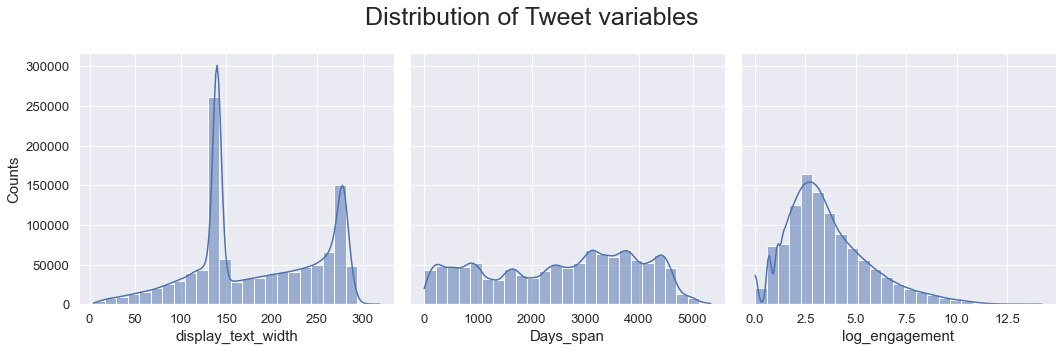

In [81]:
hist_colname = ['display_text_width','Days_span','log_engagement']
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))
for c in range(3):
    b = sns.histplot(full_tweets_data[hist_colname[c]], kde=True, bins=25, ax=axs[c])
    b.set_xlabel(hist_colname[c], fontsize=15)
    b.set_ylabel("Counts", fontsize=15)
fig.suptitle('Distribution of Tweet variables',fontsize=25) 
plt.show()

### 2.3.2 Distribution of User variables

We made a matrix plot of the distribution of the five log-transformed user variables as follows. Due to the huge amount of data, we only selected 1% of the data (about 10,000 data) to observe the relationship between user variables. 

A density curves on the diagonal indicates that all five variables approximately follow a normal distribution. The binary density contour plots in the lower triangle shows that any two of the five variables approximately follow a two-dimensional normal distribution, but there are some outliers. The regression plot in the upper triangle shows that all five variables are positively correlated with each other. This is in line with expectations, as all five variables are a reflection of the level of user activity.

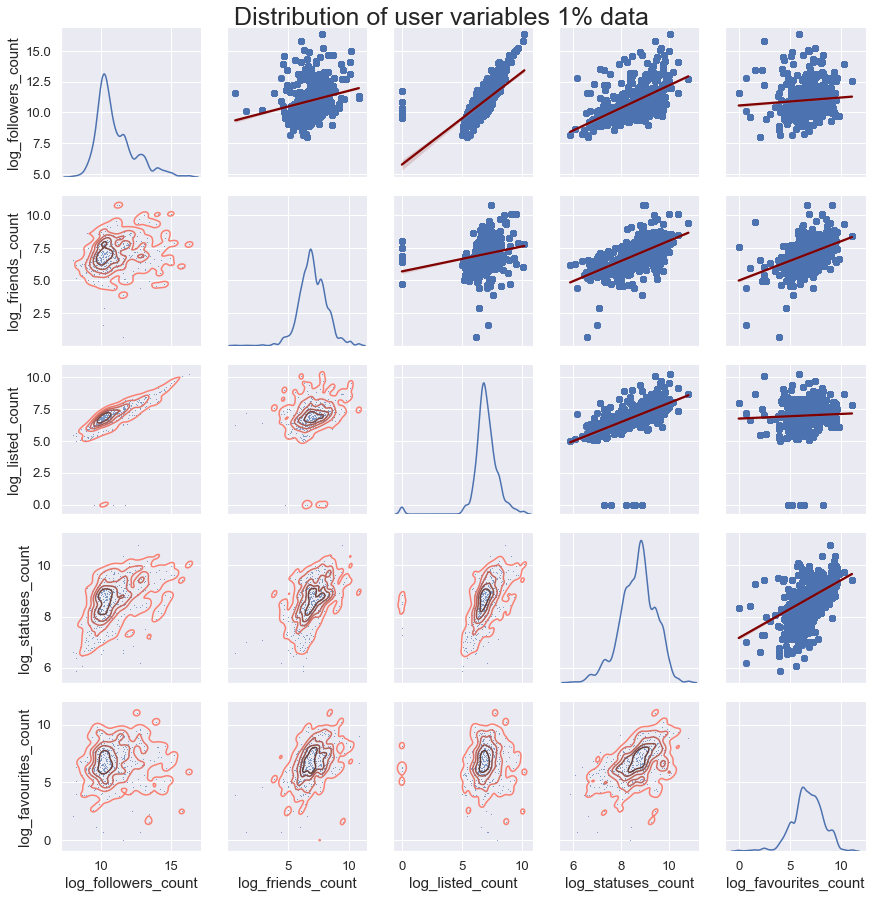

In [84]:
g = sns.PairGrid(full_tweets_data[['log_followers_count','log_friends_count','log_listed_count','log_statuses_count',
                                   'log_favourites_count']].sample(frac=0.01, replace=False, random_state=2022)) 
g.map_upper(sns.regplot, line_kws={'color':'maroon'}) 
g.map_lower(sns.scatterplot, s=0.7) 
g.map_lower(sns.kdeplot, cmap ="dark:salmon_r",levels=6) 
g.map_diag(sns.kdeplot) 
g.set(alpha=0.001)
g.fig.suptitle("Distribution of user variables 1% data", y=1, fontsize=25)
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(),fontsize=15)
    ax.set_ylabel(ax.get_ylabel(),fontsize=15)
plt.show()

### 2.3.3 Types and numbers of tweets

We made a barplot of the number of tweets, including retweets and quotes, over the years. We find that the number of tweets continues to rise from 2009 to 2021, showing almost exponential growth. In addition, original tweets account for a larger proportion, about 70%, while retweets and quotes together account for about 30%. The number of retweets is a bit more than the number of quotes. 

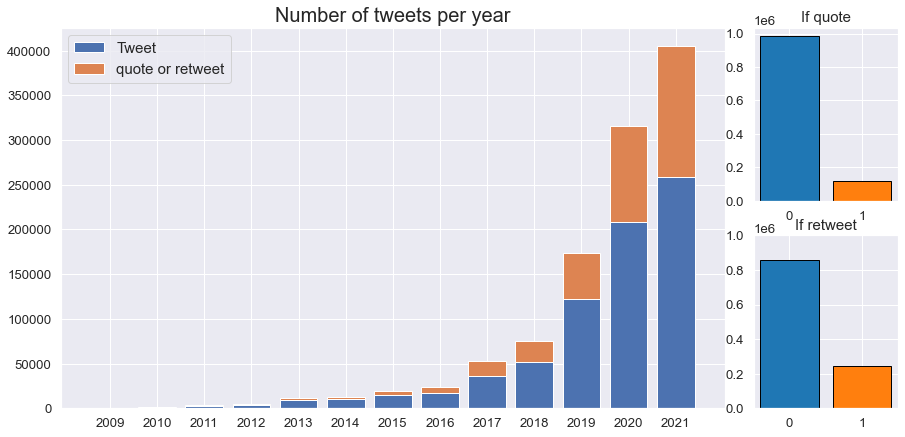

In [ ]:
full_tweets_data['quote_or_retweet'] = (full_tweets_data['is_quote'] | full_tweets_data['is_retweet'])
stackbarData = full_tweets_data[['quote_or_retweet','tweet_year']].copy()
stackbarData['count'] = 1 
stackbarData = stackbarData.groupby(['tweet_year', 'quote_or_retweet'])['count'].sum().unstack().fillna(0)

is_quote_count = full_tweets_data['is_quote'].value_counts()
is_retweet_count = full_tweets_data['is_retweet'].value_counts()
tweet_year_count = full_tweets_data['tweet_year'].value_counts()

# Setting up the plot surface
fig = plt.figure(figsize=(15, 7))
gs = GridSpec(nrows=2, ncols=5)
# First axes
ax0 = fig.add_subplot(gs[:, 0:4])
ax0.bar(stackbarData.index, stackbarData[0], label='Tweet')
ax0.bar(stackbarData.index, stackbarData[1], bottom=stackbarData[0], label='quote or retweet')
ax0.set_xticks(tweet_year_count.index)
ax0.legend(prop={'size': 15})
plt.title('Number of tweets per year', fontsize=20)

# Second axes
ax1 = fig.add_subplot(gs[0, 4])
ax1.bar(is_quote_count.index, is_quote_count, color=['#1f77b4', '#ff7f0e'], edgecolor='black')
ax1.set_title('If quote', fontsize=15)
#ax1.set_ylim((0.0, 1e6))

# Third axes
ax2 = fig.add_subplot(gs[1:,4])
ax2.bar(is_retweet_count.index, is_retweet_count, color=['#1f77b4', '#ff7f0e'], edgecolor='black')
ax2.set_title('If retweet', fontsize=15)
ax2.set_ylim((0.0, 1e6))
plt.show()

### 2.3.4 Number of tweets and engagement by states

In this section, we explore the number of tweets and engagement by state in the United States based on the user's location variable ($location$). For better visualization, we downloaded the US Geojson data and merged the Twitter data with it in the next steps and displayed it in the map

- #### Mapping locations to states 

We created a state dictionary containing information such as keywords and abbreviations for states, which are used to map location variables in the original data to state names.

In [88]:
statesDic = {'AL':['Alabama', 'AL', 'Ala.'], 'AK':['Alaska','AK','Alaska'], 'AZ':['Arizona','AZ','Ariz.'],
'AR':['Arkansas','AR','Ark.'], 'CA':['California','CA','Calif.','San Diego','San Francisco'],
'CO':['Colorado','CO','Color.'], 'CT':['Connecticut','CT','Conn.'], 'DE':['Delaware','DE','Del.'],
'FL':['Florida','FL','Fla.'], 'GA':['Georgia','GA','Ga.','Brookhaven'], 
'HI':['Hawaii','HI','Hawaii','ÜT: 19.72105,-155.087417'], 'ID':['Idaho','ID','Idaho','Boise'],
'IL':['Illinois','IL','Ill.'], 'IN':['Indiana','IN','Ind.'], 'IA':['Iowa','IA','Iowa'], 'KS':['Kansas','KS','Kan.'],
'KY':['Kentucky','KY','Ky.'], 'LA':['Louisiana','LA','La.'], 'MA':['Massachusetts','MA','Mass.'],
'ME':['Maine','ME','Maine'], 'MD':['Maryland','MD','Md.'], 'MI':['Michigan','MI','Mich.'],
'MN':['Minnesota','MN','Minn.'], 'MS':['Mississippi','MS','Miss.'], 'MO':['Missouri','MO','Mo.'],
'MT':['Montana','MT','Mont.'], 'NE':['Nebraska','NE','Neb.'], 'NV':['Nevada','NV','Nev.'], 
'NH':['New Hampshire','NH','N.H.'], 'NJ':['New Jersey','NJ','N.J.'], 'NM':['New Mexico','NM','N.M.'],
'NY':['New York','NY','N.Y.'], 'NC':['North Carolina','NC','N.C.'], 'ND':['North Dakota','ND','N.D.'],
'OH':['Ohio','OH','Ohio','Cincinnati','OH08'], 'OK':['Oklahoma','OK','Okla.'], 'OR':['Oregon','OR','Ore.'],
'PA':['Pennsylvania','PA','Pa.'], 'RI':['Rhode Island','RI','R.I.'], 'SC':['South Carolina','SC','S.C.'],
'SD':['South Dakota','SD','S.Dak.'], 'TN':['Tennessee','TN','Tenn.'], 'TX':['Texas','TX','Tex.','TX-23','Swamp'],
'UT':['Utah','UT','Utah'], 'VT':['Vermont','VT','V.T.'], 'VA':['Virginia','VA','Va.'], 
'WA':['Washington','WA','Wash.'], 'WV':['West Virginia','WV','W.Va.'], 'WI':['Wisconsin','WI','Wis.'],
'WY':['Wyoming','WY','Wyo.'], 'DC':['District of Columbia','DC','D.C.','US Congress','1216 LHOB'],
'GU':['Guam','GU','Guam'], 'MH':['Marshall Islands','MH','M.I.'], 'MP':['Northern Mariana Island','MP','CNMI'],
'PR':['Puerto Rico','PR','P.R.', 'PUR'], 'VI':['Virgin Islands','VI','V.I.'], 'AS':['American Samoa','AS']}

In [89]:
import re
location_words = [re.split('; |,|-|#|, |\'|’|\n| ', full_tweets_data['location'][i]) 
                  for i in range(len(full_tweets_data))]
location_Keywords= [set(location_words[i]).intersection(set(statesDic)) for i in range(len(full_tweets_data))]
Loc_state = [list(i)[0] if i else 'unknown' for i in location_Keywords] 
for i in range(len(full_tweets_data)):
    if Loc_state[i]=='unknown':
        for k,v in statesDic.items():
            if set(location_words[i]).intersection(set(v)):
                Loc_state[i] = k
    if Loc_state[i]=='unknown':
        for k,v in statesDic.items():
            if v[0] in full_tweets_data['location'][i]:
                Loc_state[i] = k
    if Loc_state[i]=='unknown':
        for k,v in statesDic.items():
            if any([w in full_tweets_data['location'][i] for w in v[2:]]):
                Loc_state[i] = k
                
full_tweets_data['Loc_state'] = Loc_state

- #### Geojson data

We downloaded the U.S. Geojson data and removed three states outside the U.S. mainland: Alaska, Hawaii, and Puerto Rico.

In [91]:
import geopandas as gpd
import geoplot as gplt
geoData = gpd.read_file(r'./us_states.topo.json')
geoData.id  = geoData.index
stateToRemove = ['Alaska','Hawaii','Puerto Rico']
geoData = geoData[~geoData.NAME.isin(stateToRemove)]

- #### Display data for all years together 

We merged the Twitter data with the Geojson map data. 

A blue map shows the number of tweets by state in the U.S. A darker blue for a state indicates a higher number of tweets from users in that state. As you can see, California clearly has large number of tweets, followed by Texas and some states in the eastern part of the US. The D.C. area actually has the highest number of tweets, but it's not easy to see because the area is so small. This is because there are many government agencies in D.C. that have many official tweets. There are fewer tweets from the Midwest. This tweet distribution largely coincides with the distribution of the U.S. population.

The red map shows the average engagement of tweets from each state. We learn from the plot that Tweets from Vermont have the highest average engagement. In addition, Utah, Wisconsin, Wyoming, and etc. also have relative high tweet engagement. One reason for this may be that these states have fewer tweets being recorded, while all of these tweets have higher engagement.

In [94]:
map_num_data = full_tweets_data[['log_engagement', 'Loc_state']].copy()
map_num_data['count'] = 1
map_num_data['stateNAME'] = ['unknown' if map_num_data['Loc_state'][i]=='unknown' 
                             else statesDic[map_num_data['Loc_state'][i]][0] for i in range(len(map_num_data))]
map_num_data_all = map_num_data.groupby('stateNAME', as_index =False)[['log_engagement']].mean()
map_num_data_all['count'] = map_num_data.groupby('stateNAME', as_index =False)['count'].sum()['count']
map_num_data_all['log_count'] = np.log(map_num_data_all['count'])
fullData = geoData.merge(map_num_data_all, left_on=['NAME'], right_on=['stateNAME'])

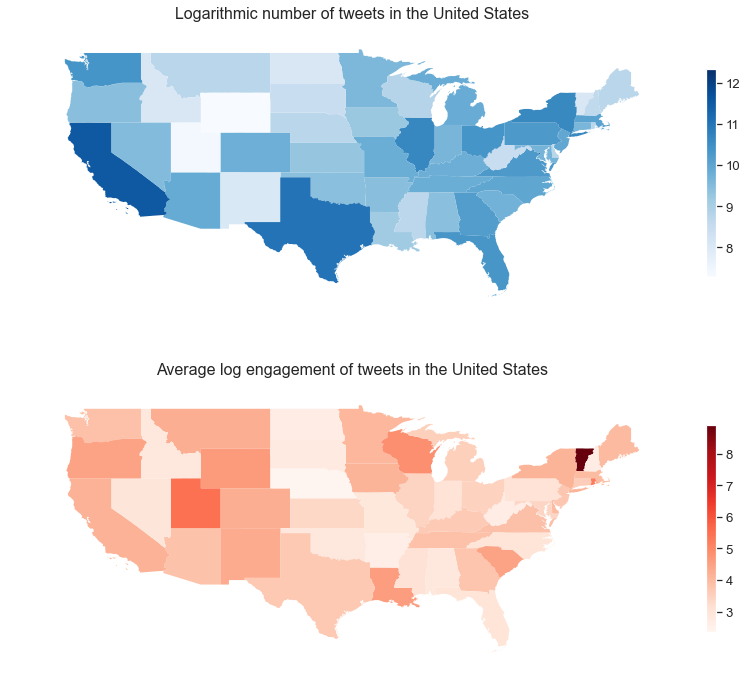

In [95]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1, figsize=(16, 12))
gplt.choropleth(fullData, 
    hue="log_count", 
    linewidth=0,
    cmap='Blues',
    legend=True,
    edgecolor='black',
    ax=ax[0],     
    legend_kwargs={'shrink':.7,'pad':0.01})
ax[0].set_title('Logarithmic number of tweets in the United States', fontsize=16);
gplt.choropleth(fullData, 
    hue="log_engagement", 
    linewidth=0,
    cmap='Reds',
    legend=True,
    edgecolor='black',
    ax=ax[1],
    legend_kwargs={'shrink':.7,'pad':0.01})
ax[1].set_title('Average log engagement of tweets in the United States', fontsize=16)
plt.show()

- #### Display yearly data

According to Section 2.3.3 we know that the number of tweets varies widely from year to year. Therefore we separate the tweets by year and make a US map of tweet engagement for each year. Because there is less data from earlier years, the Twitter data from 2019 to 2021 is more valuable and representative. Twitter engagement has increased relatively quickly in recent years in New Mexico, Vermont and Utah. 


In [100]:
map_num_data_yearly = full_tweets_data[['Loc_state','tweet_year','log_engagement']].copy()
map_num_data_yearly['tweet_year'] = map_num_data_yearly['tweet_year'].apply(str)
map_num_data_yearly['stateNAME'] = ['unknown' if map_num_data_yearly['Loc_state'][i]=='unknown' else 
                         statesDic[map_num_data_yearly['Loc_state'][i]][0] for i in range(len(map_num_data_yearly))]
map_num_data_all_yearly = map_num_data_yearly.groupby(['stateNAME','tweet_year'],as_index =False)['log_engagement'].mean()
map_num_data_all_yearly = map_num_data_all_yearly.pivot(index='stateNAME', columns='tweet_year', values='log_engagement')
fullData_yearly = geoData.merge(map_num_data_all_yearly, left_on=['NAME'], right_on=['stateNAME'])

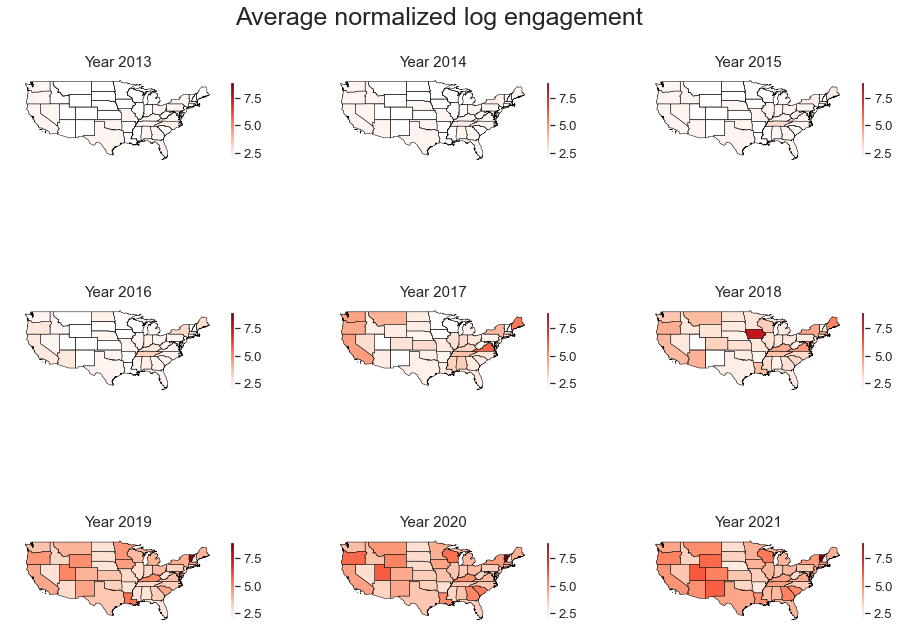

In [101]:
import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
norm = matplotlib.colors.Normalize(vmin=2, vmax=9)

years = range(2013,2022) 
for r in range(3):
    for c in range(3):  
        gplt.choropleth(fullData_yearly, 
            hue=str(years[r*3+c]), 
            linewidth=0.5,
            cmap='Reds',
            norm=norm,
            legend=True,
            edgecolor='black',
            ax=axs[r,c],
            legend_kwargs={'shrink':.4,'pad':0.01}
            )
        axs[r,c].set_xticklabels([])
        axs[r,c].set_yticklabels([])
        axs[r,c].set_title('Year %s'%(str(years[r*3+c])), fontsize=15)
fig.suptitle('Average normalized log engagement', y=0.9, fontsize=25) 
plt.show()

### 2.3.5  Five engagement levels of target variable

We categorized engagement (sum of favorites and retweets) into five levels: very low, low, moderate, high, and very high. 

In order to make the number of the five categories as balanced as possible, the rules for classifying the levels are as follows: 

- Very low:    $\quad$   1 $\leq$ Engagement $<$ 10 
- Low: $\quad$ $\quad$  10 $\leq$ Engagement $<$ 20 
- Moderate:    $\quad$  20 $\leq$ Engagement $<$ 50 
- High:$\quad$ $\quad$  50 $\leq$ Engagement $<$ 200 
- Very high:   $\quad$ 200 $\leq$ Engagement 

Finally, the numbers of tweets for each of the five engagement levels are 194199, 138538, 152977, 125507, and 127924, respectively. 

Note, since there is a fundamental difference between a quote or retweet and an original tweet, in our task we only classify the engagement of original tweets. 

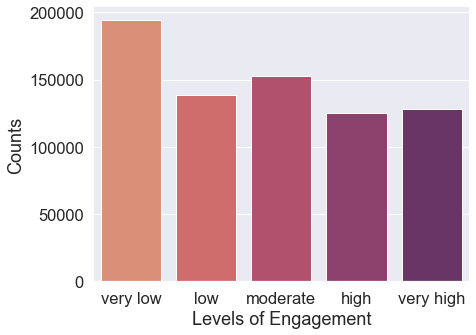

In [122]:
full_tweets_data = full_tweets_data[(full_tweets_data['is_quote'] == 0) & (full_tweets_data['is_retweet'] == 0)]
full_tweets_data['level']=[0 if (i>=np.log(1) and i<np.log(10) ) else 1 if (i>=np.log(10) and i<np.log(20)) else 2 if (i>=np.log(20) and i<np.log(50)) 
                           else 3 if (i>=np.log(50) and i<np.log(200)) else 4 for i in full_tweets_data['log_engagement']] 
sns.set(font_scale=1.5) 
g = sns.catplot(x="level", kind="count",  palette='flare', data=full_tweets_data)
g.fig.set_size_inches(8,5)
g.set_axis_labels(x_var="Levels of Engagement", y_var="Counts")
g.set(xticklabels=['very low','low','moderate','high','very high'])
plt.show()

In [123]:
Classification_labels = full_tweets_data.level.values

### 2.3.6  Text Processing

We simply processed the tweets, removing some line breaks, tabs and other useless symbols.

In [132]:
text_sentences = full_tweets_data.text.values
for i in range(len(text_sentences)):
    text_sentences[i] = text_sentences[i].replace('\xa0',' ').replace('&amp',' ').replace('\r', '').replace('\n', '')
print("An example of a Twitter text:")
print("-----------------------------")
print(text_sentences[0])

An example of a Twitter text:
-----------------------------
On December 6, 1865, America moved one step closer to our highest ideals when the 13th Amendment was ratified, ending slavery.  The arc of the moral universe bends towards justice, but it does not bend without people standing up  ; pushing for what's right.


## 2.4 Model selection and validation

### 2.4.1 Split data: training dataset & test dataset 

We randomly select 70% of the samples as the training set for training the model and the remaining 30% for validating the model.

Note that in order to make the experimental results comparable, the training and testing sets of all models in this project are identical.

In [134]:
import torch
import random
from torch.utils.data import TensorDataset, random_split
train_size = int(0.7 * len(full_tweets_data))
test_size = len(full_tweets_data) - train_size

seed_val = 2022
torch.manual_seed(2022)
random.seed(seed_val)
train_dataset_id, test_dataset_id = random_split(torch.tensor(full_tweets_data.index), [train_size, test_size])
full_tweets_data_train = full_tweets_data.loc[list(train_dataset_id)]
full_tweets_data_test = full_tweets_data.loc[list(test_dataset_id)]
print('training dataset:',train_size)
print('test dataset:',test_size)

training dataset: 517401
test dataset: 221744


### 2.4.2 Two machine learning models with numerical input: Naive bayes and Logistic regression 

First we use three traditional machine learning models as the baseline models to see what the results would be if we predicted Levels of Engagement based on only some user variables (followers_count, friends_count, listed_count, statuses_count, and favourites_count) and tweet variables (Days_span and display_text_width).

Because of the huge amount of data and the limitation of computational power, we choose the model with fast classification speed. The three models we selected are: $Naive\ bayes$ and $Logistic\ regression$. 

Before feeding the data into the models, we standardize all the variable values with maximum-minimum standardization method.

- #### Normalize data 

In [13]:
basedline_X_train = torch.tensor(full_tweets_data_train[['log_followers_count','log_friends_count','log_listed_count',
                                       'log_statuses_count', 'log_favourites_count', 'Days_span',
                                       'display_text_width']].copy().astype("float").values)
basedline_y_train = full_tweets_data_train['level'].copy()
basedline_X_train_scaled = (basedline_X_train-basedline_X_train.min(0, keepdim=True).values)/(basedline_X_train.max(0, keepdim=True).values - basedline_X_train.min(0, keepdim=True).values) #Rescale 
basedline_X_test = torch.tensor(full_tweets_data_test[['log_followers_count','log_friends_count','log_listed_count',
                                       'log_statuses_count', 'log_favourites_count', 'Days_span',
                                       'display_text_width']].copy().astype("float").values)
basedline_y_test = full_tweets_data_test['level'].copy()
basedline_X_test_scaled = (basedline_X_test-basedline_X_test.min(0, keepdim=True).values)/(basedline_X_test.max(0, keepdim=True).values - basedline_X_test.min(0, keepdim=True).values) #Rescale 

- #### Baseline Model 1:  Naive bayes 

In [137]:
from sklearn.naive_bayes import GaussianNB
NBclassifier  = GaussianNB()
NBclassifier.fit(basedline_X_train_scaled,basedline_y_train)
y_pred_NB = NBclassifier.predict(basedline_X_test_scaled)
print(classification_report(basedline_y_test,y_pred_NB))

              precision    recall  f1-score   support

           0       0.43      0.67      0.52     58332
           1       0.28      0.18      0.22     41587
           2       0.28      0.23      0.25     45659
           3       0.31      0.21      0.25     37667
           4       0.56      0.60      0.58     38499

    accuracy                           0.40    221744
   macro avg       0.37      0.38      0.36    221744
weighted avg       0.37      0.40      0.37    221744



- #### Baseline Model 2: Logistic Regression

In [138]:
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
lgcclassifier = LogisticRegression(multi_class='multinomial',solver ='newton-cg')
lgcclassifier.fit(basedline_X_train_scaled,basedline_y_train)
y_pred_logit = lgcclassifier.predict(basedline_X_test_scaled)
print(classification_report(basedline_y_test,y_pred_logit))

              precision    recall  f1-score   support

           0       0.45      0.74      0.56     58332
           1       0.31      0.12      0.17     41587
           2       0.33      0.31      0.32     45659
           3       0.33      0.21      0.26     37667
           4       0.61      0.68      0.64     38499

    accuracy                           0.43    221744
   macro avg       0.41      0.41      0.39    221744
weighted avg       0.41      0.43      0.40    221744



### 2.4.3  BERT for text classification 

Bidirectional Encoder Representations from Transformers (BERT)$^{[1]}$ is a Transformer-based machine learning technique for natural language processing (NLP) developed by Google. The BERT model can achieve state-of-the-art results for many NLP tasks such as text classification and question answering. In our classification task, we will use tweet texts to train a BERT model for tweet engagement classification.  

We follow the suggestion from the author of the paper. We followed the suggestion of the paper authors and trained the pre-trained BERT model on the tweet training set with learning rate (Adam) 2e-5 for two epochs. 

Note that because of the limited computational resources, the two epochs are not performed consecutively; instead, we train one epoch first, save the model, and then train the second epoch using the saved results as the start point.

In [10]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


- #### Text input preparation

In [ ]:
#!pip install transformers
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [ ]:
#<we have saved the results to input_ids.pt, attention_masks.pt, and labels.pt>
input_ids, attention_masks = [] , []
for sent in text_sentences:
    encoded_dict = tokenizer.encode_plus(sent, add_special_tokens = True, truncation=True,
                        padding='max_length',
                        max_length = 100,  #Pad & truncate all sentences (since 0.99 quantile is 93)
                        return_attention_mask = True, return_tensors = 'pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
# Convert lists to torch.tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Classification_labels)

In [14]:
# for colab:
# input_ids = torch.load('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/input_ids.pt')
# attention_masks = torch.load('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/attention_masks.pt')
# labels = torch.load('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/labels.pt')
#for local:
input_ids = torch.load('./input_ids.pt')
attention_masks = torch.load('./attention_masks.pt')
labels = torch.load('./labels.pt')

- #### Training & test dataset of the prepared text (with same random seed)

In [15]:
from torch.utils.data import TensorDataset, random_split
import random
seed_val = 2022
torch.manual_seed(2022)
random.seed(seed_val)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} test samples'.format(test_size))

517,401 training samples
221,744 test samples


In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size)
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size)

- #### Load blank pre-trained model (for the first-epoch training)

In [ ]:
#after training, we have saved the model to BERTbase_TwitterSeqClass_epoch1 fold
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels = 5,
    output_attentions = False, 
    output_hidden_states = False)

- #### Load Epoch-1 model (for the second-epoch training)

In [ ]:
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch1') # model with epoch 1 
tokenizer = tokenizer.from_pretrained(output_dir)
model.to(device)

- #### Define the learning rate, epsilon, epochs

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8) 
from transformers import get_linear_schedule_with_warmup
epochs = 1 #Every time one epoch, we trained the second epoch start from the first eopch result.
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

- #### Function for calculating accuracy

In [20]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

- #### Function for timing

In [19]:
import time, datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))    
    return str(datetime.timedelta(seconds=elapsed_rounded))

- #### Training process

In [ ]:
import random
import os
#after training, we have saved the model(epoch2) to BERTbase_TwitterSeqClass_epoch2 fold

seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

total_t0 = time.time()
for epoch_i in range(1, epochs+1):  #since we start from epoch 1 model
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, 2))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0.0

    model= model.to(device)
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 150 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels, return_dict=True)
        loss = result.loss
        logits = result.logits

        # Update loss
        total_train_loss += loss.item()
        # Perform a backward calculation
        loss.backward()
        # prevent the "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters 
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    #save every epoch model
    output_dir='/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch'+str(epoch_i+1)+'/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print("Saving model to %s" % output_dir)
    model_to_save = model.module if hasattr(model, 'module') else model  
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 2 / 2 ========
Training...
  Batch   150  of  16,169.    Elapsed: 0:01:15.
  Batch   300  of  16,169.    Elapsed: 0:02:31.
  Batch   450  of  16,169.    Elapsed: 0:03:50.
  Batch   600  of  16,169.    Elapsed: 0:05:10.
  Batch   750  of  16,169.    Elapsed: 0:06:30.
  Batch   900  of  16,169.    Elapsed: 0:07:49.
  Batch 1,050  of  16,169.    Elapsed: 0:09:08.
  Batch 1,200  of  16,169.    Elapsed: 0:10:28.
  Batch 1,350  of  16,169.    Elapsed: 0:11:47.
  Batch 1,500  of  16,169.    Elapsed: 0:13:07.
  Batch 1,650  of  16,169.    Elapsed: 0:14:26.
  Batch 1,800  of  16,169.    Elapsed: 0:15:46.
  Batch 1,950  of  16,169.    Elapsed: 0:17:05.
  Batch 2,100  of  16,169.    Elapsed: 0:18:25.
  Batch 2,250  of  16,169.    Elapsed: 0:19:44.
  Batch 2,400  of  16,169.    Elapsed: 0:21:04.
  Batch 2,550  of  16,169.    Elapsed: 0:22:23.
  Batch 2,700  of  16,169.    Elapsed: 0:23:43.
  Batch 2,850  of  16,169.    Elapsed: 0:25:03.
  Batch 3,000  of  16,169.    Elapsed: 0:26:2

- #### Prediction on test dataset

In [ ]:
BERT_Only_model_2 = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch2') # model with epoch 2
tokenizer_BERT = tokenizer.from_pretrained('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch2')
BERT_Only_model_2.to(device)

In [ ]:
# we have saved the prediction results to BERTonly2_predictions.npy
print('Predicting labels for {:,} test sentences...'.format(test_size))
BERT_Only_model_2.eval()

predictions , true_labels = [], []
t0 = time.time()
for step, batch in enumerate(test_dataloader):
    if step % 150 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))
  
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        result = BERT_Only_model_2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, return_dict=True)
    logits = result.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
predicting_time = format_time(time.time() - t0)
print('-----DONE.-----')
print("predicting process took: {:}".format(predicting_time))

Predicting labels for 221,744 test sentences...
  Batch   150  of  6,930.    Elapsed: 0:00:27.
  Batch   300  of  6,930.    Elapsed: 0:00:54.
  Batch   450  of  6,930.    Elapsed: 0:01:21.
  Batch   600  of  6,930.    Elapsed: 0:01:48.
  Batch   750  of  6,930.    Elapsed: 0:02:15.
  Batch   900  of  6,930.    Elapsed: 0:02:42.
  Batch 1,050  of  6,930.    Elapsed: 0:03:10.
  Batch 1,200  of  6,930.    Elapsed: 0:03:37.
  Batch 1,350  of  6,930.    Elapsed: 0:04:04.
  Batch 1,500  of  6,930.    Elapsed: 0:04:31.
  Batch 1,650  of  6,930.    Elapsed: 0:04:58.
  Batch 1,800  of  6,930.    Elapsed: 0:05:25.
  Batch 1,950  of  6,930.    Elapsed: 0:05:52.
  Batch 2,100  of  6,930.    Elapsed: 0:06:19.
  Batch 2,250  of  6,930.    Elapsed: 0:06:46.
  Batch 2,400  of  6,930.    Elapsed: 0:07:14.
  Batch 2,550  of  6,930.    Elapsed: 0:07:41.
  Batch 2,700  of  6,930.    Elapsed: 0:08:08.
  Batch 2,850  of  6,930.    Elapsed: 0:08:35.
  Batch 3,000  of  6,930.    Elapsed: 0:09:02.
  Batch 3,15

- #### Evaluation

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     58332
           1       0.33      0.27      0.30     41587
           2       0.33      0.40      0.36     45659
           3       0.34      0.30      0.32     37667
           4       0.56      0.59      0.57     38499

    accuracy                           0.45    221744
   macro avg       0.44      0.44      0.44    221744
weighted avg       0.45      0.45      0.45    221744



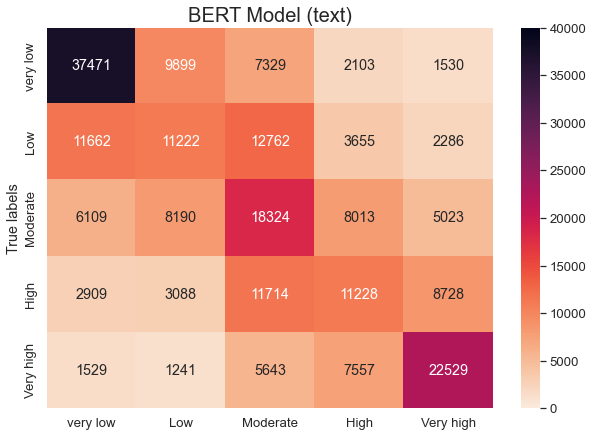

In [145]:
from sklearn.metrics import classification_report, confusion_matrix
# For colab:
# predictions_BERT_2 = np.load('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch2/BERTonly2_predictions.npy')
# test_true_labels = np.load('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch2/true_labels.npy')
# For local:
predictions_BERT_2 = np.load('./BERTbase_TwitterSeqClass_epoch2/BERTonly2_predictions.npy')
test_true_labels = np.load('./BERTbase_TwitterSeqClass_epoch2/true_labels.npy')
predictions_BERT_2_labels = np.argmax(predictions_BERT_2, axis=1).flatten()
print(classification_report(test_true_labels, predictions_BERT_2_labels))

sns.set(font_scale=1.2)
plt.figure(figsize = (10,7))
c_Matrix = confusion_matrix(test_true_labels, predictions_BERT_2_labels)
heatmap = sns.heatmap(c_Matrix, annot=True, cmap='rocket_r',xticklabels=['very low','Low','Moderate','High','Very high'],
                     yticklabels=['very low','Low','Moderate','High','Very high'], vmin=0, vmax=40000,fmt='g')
plt.title('BERT Model (text)', fontsize=20)
plt.ylabel("True labels") 
plt.show()

### 2.4.4  BERT + DNN model 

In the previous section we trained the BERT classification model using plain text as input, but this did not make use of the information of numerical variables in the data. Therefore, in this section, we add user variables and tweet variables to the model to take advantage of both textual and numerical information.

Our idea is to use the output obtained from BERT text prediction as features of textual information. Since our task is a five-classification model, each piece of tweet data will get 5 features from the BERT model, which represent textual information. Then we merge these five BERT features with the original 7 numerical variables, making a total of 12 variables in the dataset. Then we created a neural network model for tweet engagement classification using these 12 variables.

- #### Prepare BERT text feature

In [ ]:
BERT_Only_model_2 = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch2') # model with epoch 2
tokenizer_BERT = tokenizer.from_pretrained('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch2')
BERT_Only_model_2.to(device)

In [24]:
# we have saved the BERT text features to BERT_features5.npy
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
seq_train_dataloader = DataLoader( train_dataset,
            sampler = SequentialSampler(train_dataset), # Select batches sequentially
            batch_size = batch_size)

print('Obtaining BERT features for {:,} training sentences...'.format(train_size))
BERT_Only_model_2.eval()
features5  = [] 
t0 = time.time()
for step, batch in enumerate(seq_train_dataloader):
    if step % 1000 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(seq_train_dataloader), elapsed))
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        result = BERT_Only_model_2(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)
    logits = result.logits
    logits = logits.detach().cpu().numpy()
    features5.append(logits)

predicting_time = format_time(time.time() - t0)
print('-----DONE.-----')
print("Obtaining feature process took: {:}".format(predicting_time))

Obtaining BERT features for 517,401 training sentences...
  Batch 1,000  of  16,169.    Elapsed: 0:03:10.
  Batch 2,000  of  16,169.    Elapsed: 0:06:40.
  Batch 3,000  of  16,169.    Elapsed: 0:10:11.
  Batch 4,000  of  16,169.    Elapsed: 0:13:43.
  Batch 5,000  of  16,169.    Elapsed: 0:17:15.
  Batch 6,000  of  16,169.    Elapsed: 0:20:47.
  Batch 7,000  of  16,169.    Elapsed: 0:24:19.
  Batch 8,000  of  16,169.    Elapsed: 0:27:52.
  Batch 9,000  of  16,169.    Elapsed: 0:31:24.
  Batch 10,000  of  16,169.    Elapsed: 0:34:56.
  Batch 11,000  of  16,169.    Elapsed: 0:38:29.
  Batch 12,000  of  16,169.    Elapsed: 0:42:01.
  Batch 13,000  of  16,169.    Elapsed: 0:45:32.
  Batch 14,000  of  16,169.    Elapsed: 0:49:04.
  Batch 15,000  of  16,169.    Elapsed: 0:52:35.
  Batch 16,000  of  16,169.    Elapsed: 0:56:06.
-----DONE.-----
Obtaining feature process took: 0:56:42


- #### Combine BERT text features and User/Tweet numerical features 

In [17]:
# for colab:
# BERT_features_train = np.load('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch2/BERT_features5.npy',allow_pickle=True)
# BERT_features_test = np.load('/content/drive/MyDrive/Colab_Notebooks/2022GWUDatathon/BERTbase_TwitterSeqClass_epoch2/BERTonly2_predictions.npy',allow_pickle=True)
# for local:
BERT_features_train = np.load('./BERTbase_TwitterSeqClass_epoch2/BERT_features5.npy',allow_pickle=True)
BERT_features_test = np.load('./BERTbase_TwitterSeqClass_epoch2/BERTonly2_predictions.npy',allow_pickle=True)
BERT_features_train = np.concatenate(BERT_features_train, axis=0)
Combo_features_TrainData = full_tweets_data_train[['log_followers_count','log_friends_count','log_listed_count',
                 'log_statuses_count', 'log_favourites_count', 'Days_span','display_text_width','level']].copy()
for i in range(5):
    Combo_features_TrainData['bert'+str(i+1)] = list(BERT_features_train[:,i])

BERT_features_test = BERT_features_test
Combo_features_TestData = full_tweets_data_test[['log_followers_count','log_friends_count','log_listed_count',
                 'log_statuses_count', 'log_favourites_count', 'Days_span','display_text_width','level']].copy()
for i in range(5):
    Combo_features_TestData['bert'+str(i+1)] = list(BERT_features_test[:,i])
print('there are 5 user features, 2 tweet features, and 5 BERT text features')

there are 5 user features, 2 tweet features, and 5 BERT text features


- #### Normalize data

Before feeding the data into the models, we standardize all the variable values by maximum-minimum standardization method.

In [18]:
#training data: 
Combo_X_train = torch.tensor(Combo_features_TrainData.drop(['level'], axis = 1).copy().astype("float").values) #remove y 
Combo_y_train = torch.tensor(Combo_features_TrainData['level'].copy().values)
Combo_X_train_scaled = (Combo_X_train-Combo_X_train.min(0, keepdim=True).values)/(Combo_X_train.max(0, keepdim=True).values - Combo_X_train.min(0, keepdim=True).values) #Rescale 

#test data: 
Combo_X_test = torch.tensor(Combo_features_TestData.drop(['level'], axis = 1).copy().astype("float").values) #remove y 
Combo_y_test = torch.tensor(Combo_features_TestData['level'].copy().values)
Combo_X_test_scaled = (Combo_X_test-Combo_X_test.min(0, keepdim=True).values)/(Combo_X_test.max(0, keepdim=True).values - Combo_X_test.min(0, keepdim=True).values) #Rescale 

print('training X size',Combo_X_train_scaled.shape)
print('training y size',Combo_y_train.shape)
print('testing X size', Combo_X_test_scaled.shape)
print('testing y size',Combo_y_test.shape)


training X size torch.Size([517401, 12])
training y size torch.Size([517401])
testing X size torch.Size([221744, 12])
testing y size torch.Size([221744])


- #### Build a Deep Neural Network (DNN)

In [19]:
from collections import OrderedDict
import math
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

In [20]:
def softmax_loss(x, y):
    loss = None    
    N, C = x.shape[0], x.shape[1]  
    loss = F.cross_entropy(x, y, reduction='sum') * 1. / N   
    return loss

In [21]:
class DNN_model(nn.Module):
    def __init__(self, input_dim_v=12, C=5, 
                 DNN_hidden_Size=[10,5], reg=0.0, dropratio=0.5, device='cuda', dtype=torch.float):
        """
        Inputs:
        - input_dim_v: number of features
        - C: number of classes 
        - DNN_hidden_Size: list, dimension of DNN hidden layers
        - reg: regularization parameter
        - device: 'cuda' or 'cpu'
        - dtype: datatype to use
        """
        super().__init__()
        
        self.V = input_dim_v
        self.C = C 
        self.DNN_hidden_Size = DNN_hidden_Size
        self.dtype = dtype
        self.device = device
        self.reg = reg 
        self.dropratio = dropratio

        #Initialize parameters for DNN 
        W_d1 = Parameter(torch.randn(self.V, self.DNN_hidden_Size[0], device=device, dtype=dtype).div(math.sqrt(self.V)))
        exec(f'self.W_d{1} = W_d1') 
        b_d1 = Parameter(torch.zeros(self.DNN_hidden_Size[0], device=device, dtype=dtype))
        exec(f'self.b_d{1} = b_d1') 
        for i in range(2,len(self.DNN_hidden_Size)+1):
            W_di = Parameter(torch.randn(self.DNN_hidden_Size[i-2], self.DNN_hidden_Size[i-1], device=device, dtype=dtype).div(math.sqrt(self.DNN_hidden_Size[i-2])))
            exec(f'self.W_d{i} = W_di')   
            b_di = Parameter(torch.zeros(self.DNN_hidden_Size[i-1], device=device, dtype=dtype)) 
            exec(f'self.b_d{i} = b_di')   
        W_dlast = Parameter(torch.randn(self.DNN_hidden_Size[-1], self.C, device=device, dtype=dtype).div(math.sqrt(self.DNN_hidden_Size[-1])))
        exec(f'self.W_d{len(self.DNN_hidden_Size)+1} = W_dlast')   
        b_dlast = Parameter(torch.zeros(self.C, device=device, dtype=dtype))
        exec(f'self.b_d{len(self.DNN_hidden_Size)+1} = b_dlast')   
    
    def train_process(self):
        raise NotImplementedError
    
    def test_process(self):
        raise NotImplementedError

In [23]:
    def DNN_forward(self, Pointdata , y):
        """
        Inputs:
        - Pointdata: (N, V) 
        - y: (N,)
        Outputs:
        - loss: A scalar loss
        """
        loss = 0.0
        Pointdata = Pointdata.to(self.device).to(self.dtype)  #(N,V)
        groundTruth_y = y.to(torch.long).to(self.device) #(N,)
        N = Pointdata.shape[0]
      
        DNNhidden = Pointdata.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        DNNhidden = F.dropout(DNNhidden, p=self.dropratio)
        for i in range(2,len(self.DNN_hidden_Size)+1):
            DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
            DNNhidden = torch.relu(DNNhidden)  # 
            DNNhidden = F.dropout(DNNhidden, p=self.dropratio) 
        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  

        loss = softmax_loss(DNNoutput, groundTruth_y)
        return loss
    DNN_model.train_process = DNN_forward

In [24]:
    def DNN_test(self, Pointdata, y_test):
        """
        Inputs:
        - Pointdata: (N, V) 
        Outputs:
        - scalar: classficition 
        """
        Pointdata = Pointdata.to(self.device).to(self.dtype)  #(N,V)
        groundTruth_y = y_test.to(torch.long).to(self.device) #(N,)
        N = Pointdata.shape[0]

        DNNhidden = Pointdata.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        for i in range(2,len(self.DNN_hidden_Size)+1):
            DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
            DNNhidden = torch.relu(DNNhidden)   
        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))       
       
        pred_y = DNNoutput.argmax(dim=1)
        loss = softmax_loss(DNNoutput, groundTruth_y)
        return  pred_y, loss

    DNN_model.test_process = DNN_test

In [32]:
def ModelTrain(dnn_model, Point_data, y_data, lr_decay=1, **kwargs):
   # optimizer setup
    from torch import optim
    optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, dnn_model.parameters()), learning_rate)
    lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: lr_decay ** epoch)
    #batch data
    iter_per_epoch = math.ceil(Point_data.shape[0] // batch_size)
    loss_history = []
    dnn_model.train()
    for i in range(num_epochs):
        start_t = time.time()
        for j in range(iter_per_epoch):
            PointData = Point_data[j*batch_size:(j+1)*batch_size]
            y = y_data[j*batch_size:(j+1)*batch_size]
            loss = dnn_model.train_process(PointData, y)
            optimizer.zero_grad() 
            loss.backward()
            loss_history.append(loss.item())
            optimizer.step()
        end_t = time.time()
        print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(i, num_epochs, loss.item(), end_t-start_t))
        lr_scheduler.step()

    # plot the training losses
    plt.plot(loss_history, color='black')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training loss history')
    plt.show()

- #### Training the DNN with BERT text features

(Epoch 0 / 10) loss: 1.0884 time per epoch: 277.4s
(Epoch 1 / 10) loss: 1.0351 time per epoch: 321.0s
(Epoch 2 / 10) loss: 1.0412 time per epoch: 293.1s
(Epoch 3 / 10) loss: 1.0062 time per epoch: 295.2s
(Epoch 4 / 10) loss: 1.0114 time per epoch: 375.8s
(Epoch 5 / 10) loss: 1.0203 time per epoch: 361.3s
(Epoch 6 / 10) loss: 0.9947 time per epoch: 354.0s
(Epoch 7 / 10) loss: 1.0110 time per epoch: 355.8s
(Epoch 8 / 10) loss: 1.0013 time per epoch: 353.8s
(Epoch 9 / 10) loss: 1.0070 time per epoch: 353.8s


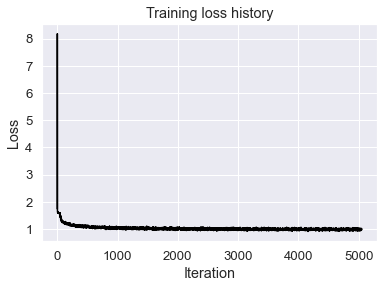

In [57]:
num_epochs = 10
batch_size = 1024 
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_float_cpu = {'dtype': torch.float, 'device': 'cpu'}

learning_rate = 1e-3
dnn_model = DNN_model(
          input_dim_v = 12, 
          C=5, 
          reg = 0.0, 
          dropratio = 0.4, 
          DNN_hidden_Size=[1024, 2048, 2048, 2048, 1024], 
          **to_float_cpu)
ModelTrain(dnn_model, Combo_X_train_scaled, Combo_y_train,
              num_epochs=num_epochs, batch_size=batch_size,
              learning_rate=learning_rate)

- #### Evaluation 

              precision    recall  f1-score   support

           0       0.68      0.65      0.66     58332
           1       0.36      0.32      0.34     41587
           2       0.38      0.40      0.39     45659
           3       0.39      0.51      0.44     37667
           4       0.78      0.61      0.69     38499

    accuracy                           0.51    221744
   macro avg       0.52      0.50      0.50    221744
weighted avg       0.52      0.51      0.51    221744



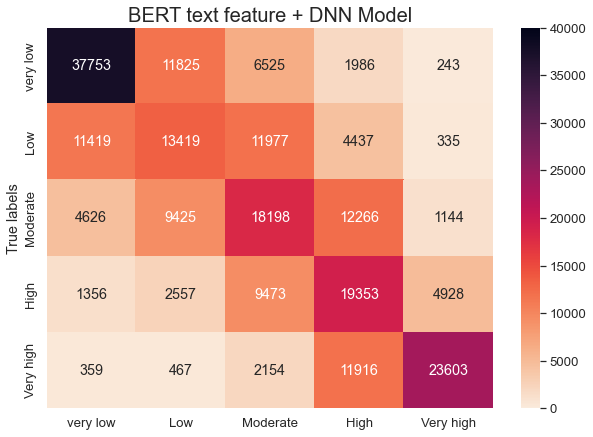

In [58]:
dnn_model = dnn_model.eval()  
predictions_BERT_DNN_labels, _ = dnn_model.test_process(Combo_X_test_scaled, Combo_y_test)
predictions_BERT_DNN_labels = predictions_BERT_DNN_labels.to('cpu')
print(classification_report(Combo_y_test, predictions_BERT_DNN_labels))
sns.set(font_scale=1.2)
plt.figure(figsize = (10,7))
c_Matrix = confusion_matrix(Combo_y_test, predictions_BERT_DNN_labels)
heatmap = sns.heatmap(c_Matrix, annot=True, cmap='rocket_r',xticklabels=['very low','Low','Moderate','High','Very high'],
                     yticklabels=['very low','Low','Moderate','High','Very high'], vmin=0, vmax=40000,fmt='g')
plt.title('BERT text feature + DNN Model', fontsize=20)
plt.ylabel("True labels") 
plt.show()

### 2.4.5  DNN only 

To demonstrate the validity and valuableness of the BERT text feature, we remove all the 5 BERT text features and then perform another classification based on only the original 7 numerical variables using the exact same DNN model and the same training and prediction process.

- #### Training the DNN with original numerical variables only

(Epoch 0 / 10) loss: 1.4315 time per epoch: 223.5s
(Epoch 1 / 10) loss: 1.3798 time per epoch: 260.2s
(Epoch 2 / 10) loss: 1.3699 time per epoch: 300.7s
(Epoch 3 / 10) loss: 1.3505 time per epoch: 307.4s
(Epoch 4 / 10) loss: 1.3560 time per epoch: 277.6s
(Epoch 5 / 10) loss: 1.3344 time per epoch: 268.4s
(Epoch 6 / 10) loss: 1.3403 time per epoch: 295.8s
(Epoch 7 / 10) loss: 1.3396 time per epoch: 278.7s
(Epoch 8 / 10) loss: 1.3424 time per epoch: 299.6s
(Epoch 9 / 10) loss: 1.3474 time per epoch: 275.1s


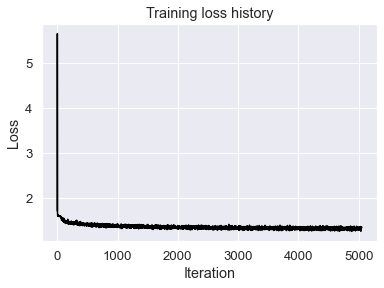

In [68]:
num_epochs = 10
batch_size = 1024 
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_float_cpu = {'dtype': torch.float, 'device': 'cpu'}

learning_rate = 1e-3
dnn_model = DNN_model(
          input_dim_v = 7, 
          C=5, 
          reg = 0.0, 
          dropratio = 0.4, 
          DNN_hidden_Size=[1024, 2048, 2048, 2048, 1024], 
          **to_float_cpu)
ModelTrain(dnn_model, basedline_X_train_scaled, torch.tensor(np.array(basedline_y_train)),
              num_epochs=num_epochs, batch_size=batch_size,
              learning_rate=learning_rate)

- #### Evaluation

              precision    recall  f1-score   support

           0       0.49      0.76      0.59     58332
           1       0.32      0.06      0.11     41587
           2       0.32      0.43      0.37     45659
           3       0.35      0.30      0.32     37667
           4       0.72      0.57      0.63     38499

    accuracy                           0.45    221744
   macro avg       0.44      0.42      0.40    221744
weighted avg       0.44      0.45      0.42    221744



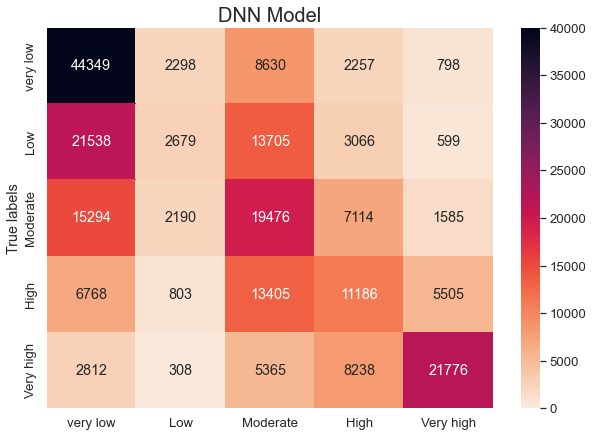

In [69]:
dnn_model = dnn_model.eval()  
predictions_DNN_labels, _ = dnn_model.test_process(basedline_X_test_scaled, torch.tensor(np.array(basedline_y_test)))
predictions_DNN_labels = predictions_DNN_labels.to('cpu')

print(classification_report(torch.tensor(np.array(basedline_y_test)), predictions_DNN_labels))
sns.set(font_scale=1.2)
plt.figure(figsize = (10,7))
c_Matrix = confusion_matrix(torch.tensor(np.array(basedline_y_test)), predictions_DNN_labels)
heatmap = sns.heatmap(c_Matrix, annot=True, cmap='rocket_r',xticklabels=['very low','Low','Moderate','High','Very high'],
                     yticklabels=['very low','Low','Moderate','High','Very high'], vmin=0, vmax=40000,fmt='g')
plt.title('DNN Model', fontsize=20)
plt.ylabel("True labels") 
plt.show()

# 3. Results 

Based on the 221,744 test data, we present the results of several models for tweet engagement classification in the following table.

Because of the large amount of data available, the results of this comparison should be fair and stable.

From the results, we know that Naive bayes and Logit models are the worst performers, with accuracy of 0.40 and 0.43, respectively. BERT (text) and DNN can improve the accuracy a little to 0.45. The model with the highest accuracy is the BERT + DNN model, which has the highest values for all four metrics: accuracy, precision, recall, and f1-score. 
The BERT + DNN model improved the four metrics by 13.3%, 18.2%, 19.0% and 27.5%, respectively, compared to the second best model. This result is reasonable because the BERT + DNN model utilizes both text features and numerical variables in the tweet dataset. 

In [167]:
from prettytable import PrettyTable 
ResultTable = PrettyTable(["Models", "Accuracy", "Precision", "Recall","F1-score"]) 
ResultTable.add_row(["Naive bayes",          '0.40', '0.37', '0.38', '0.36']) 
ResultTable.add_row(["Logit",                '0.43', '0.41', '0.41', '0.39']) 
ResultTable.add_row(["BERT(text)",           '0.45', '0.44', '0.44', '0.44']) 
ResultTable.add_row(["DNN",                  '0.45', '0.44', '0.42', '0.40']) 
ResultTable.add_row(["BERT + DNN",           '0.51', '0.52', '0.50', '0.51']) 
print(ResultTable)

+-------------+----------+-----------+--------+----------+
|    Models   | Accuracy | Precision | Recall | F1-score |
+-------------+----------+-----------+--------+----------+
| Naive bayes |   0.40   |    0.37   |  0.38  |   0.36   |
|    Logit    |   0.43   |    0.41   |  0.41  |   0.39   |
|  BERT(text) |   0.45   |    0.44   |  0.44  |   0.44   |
|     DNN     |   0.45   |    0.44   |  0.42  |   0.40   |
|  BERT + DNN |   0.51   |    0.52   |  0.50  |   0.51   |
+-------------+----------+-----------+--------+----------+


If we compare the confusion matrix of the top three best models, we can also find the advantage of the BERT + DNN model. We can see that the BERT + DNN model has the heaviest color on the diagonal of the confusion matrix and the most prominent diagonal.  

Because our task is a multi-classification task, which is more difficult compared to binary classification. In fact, the boundaries between the five engagement levels are not very clear. Although the classification result of the BERT + DNN model is not so precise, the vast majority of the test data are classified into the correct class or close classes based on the color highlighted on the diagonal of the confusion matrix, which is a good indicator of our model.

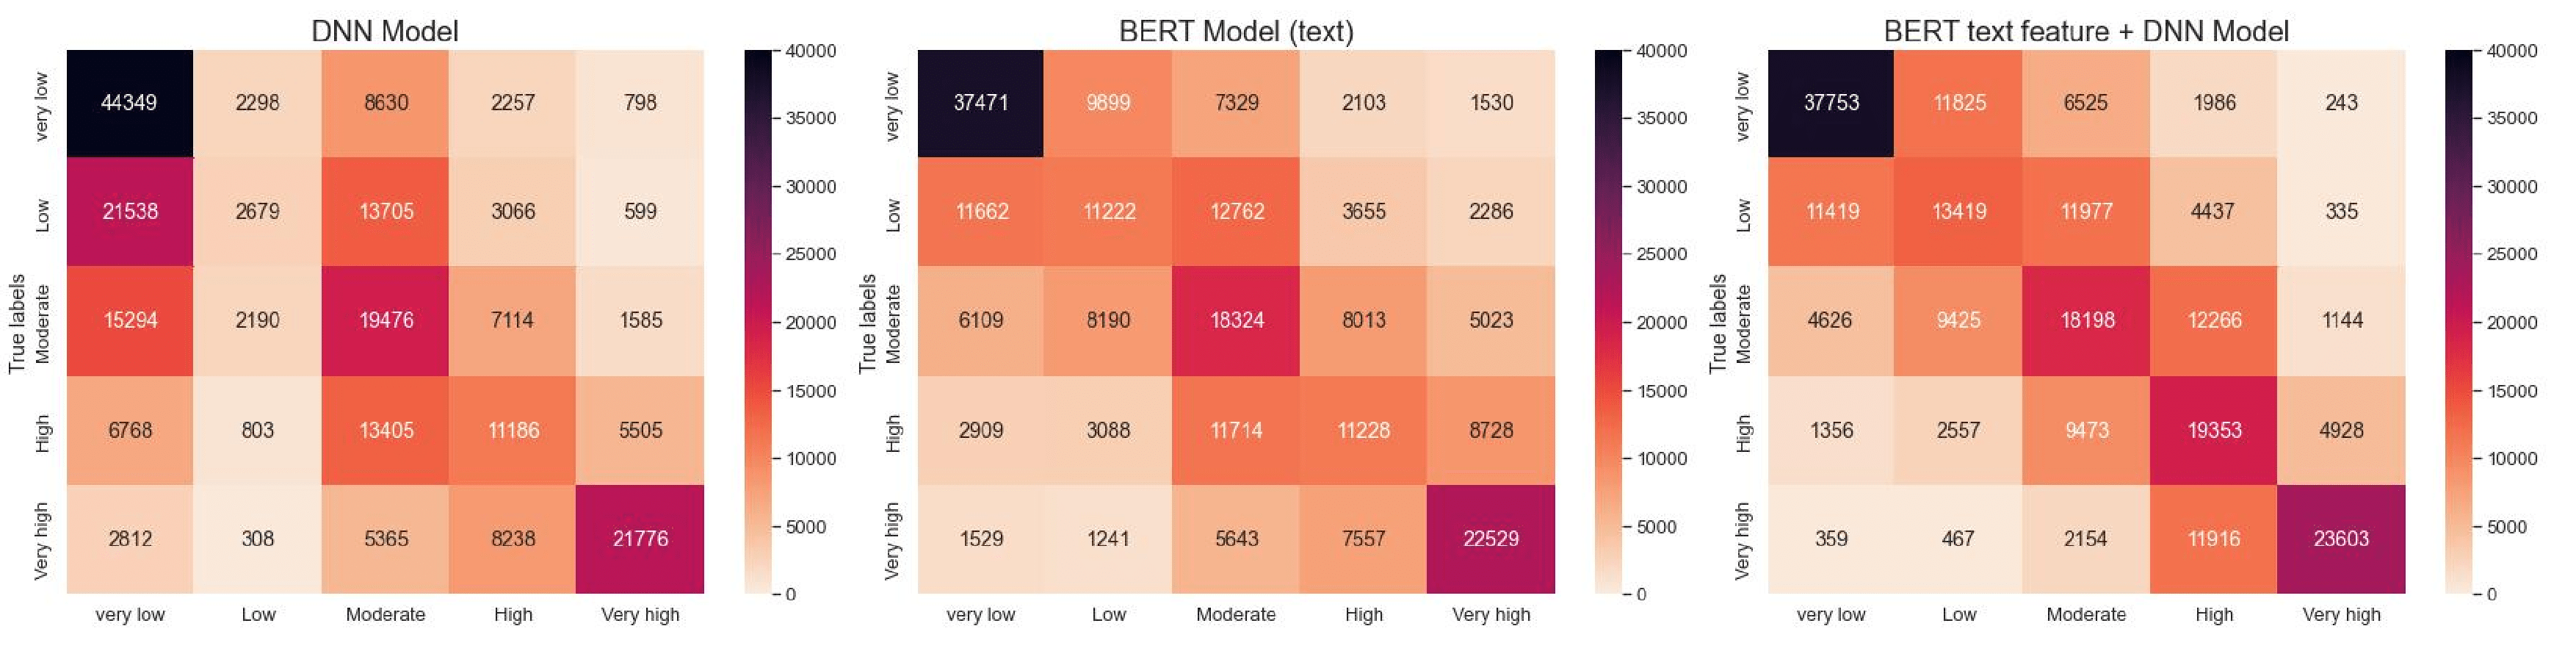

In [177]:
from IPython import display
display.Image("./Results.png")

## Reference

[1] Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).